In [1]:
!pip install ultralytics transformers timm seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os 
print(os.getcwd())

/beegfs/home/arofenitra.rarivonjy/github/arofenitra/clear-path-detection/notebook


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
from PIL import Image
import time
import threading
from collections import deque
import json
import math
import os
from dataclasses import dataclass
from typing import Tuple, List, Optional, Dict
import warnings
warnings.filterwarnings('ignore')
import os 
# os.chdir(r'../notebook')
# os.chdir("../")
# Try to import required models (install with: pip install ultralytics transformers timm)
try:
    from ultralytics import YOLO
    import timm
except ImportError:
    print("Please install: pip install ultralytics transformers timm")

@dataclass
class NavigationOutput:
    """Output structure for navigation decisions"""
    direction: str  # "forward", "left", "right", "stop"
    obstacle_distance: float
    confidence: float
    audio_message: str
    haptic_pattern: List[int]  # Vibration pattern for different motors
    traversable_ranges: List[Tuple[int, int]]  # Pixel ranges that are traversable

class DepthEstimator:
    """Depth estimation using MiDaS"""
    def __init__(self, device='cuda:0'):
        self.device = device

        # Load MiDaS model
        print("Loading MiDaS depth estimation model...")
        self.model = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid")
        self.model.to(self.device)
        self.model.eval()

        # Get the proper transform for MiDaS
        self.transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
        print("MiDaS model loaded successfully!")

    def estimate_depth(self, image):
        """Estimate depth from RGB image"""
        try:
            # Convert to PIL Image if it's a numpy array
            if isinstance(image, np.ndarray):
                # Ensure it's in RGB format
                if len(image.shape) == 3 and image.shape[2] == 3:  # BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image)
            elif not isinstance(image, Image.Image):
                raise ValueError(f"Unsupported image type: {type(image)}")
            
            # Store original dimensions
            original_size = image.size  # (width, height)
            print(f"\noriginal_size: {original_size}\n")
            image = np.array(image)
            # Apply the proper transform
            input_batch = self.transform(image).to(self.device)

            # Forward pass
            with torch.no_grad():
                prediction = self.model(input_batch)

                # Interpolate to original size
                prediction = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size=original_size[::-1],  # (height, width)
                    mode="bicubic",
                    align_corners=False
                ).squeeze()

            # Convert to numpy
            depth_map = prediction.squeeze().cpu().numpy()

            # Handle potential NaN/inf values
            depth_map = np.nan_to_num(depth_map, nan=0.0, posinf=1.0, neginf=0.0)

            # Normalize depth map
            if depth_map.max() > depth_map.min():
                depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8)
            else:
                depth_map = np.zeros_like(depth_map)  # Fallback if all values are the same

            # Invert depth map (closer objects should have higher values)
            depth_map = 1.0 - depth_map

            return depth_map

        except Exception as e:
            print(f"Depth estimation error: {e}")
            import traceback
            traceback.print_exc()

            # Return a fallback depth map
            if isinstance(image, np.ndarray):
                h, w = image.shape[:2]
            elif isinstance(image, Image.Image):
                w, h = image.size
            else:
                h, w = 480, 640  # Default size

            return np.ones((h, w)) * 0.5  # Neutral gray depth map

class SemanticSegmentation:
    """DeepLabV3+ semantic segmentation"""
    def __init__(self, device='cuda:1'):
        self.device = device
        # Load pre-trained DeepLabV3+ model
        self.model = models.segmentation.deeplabv3_resnet101(pretrained=True)
        self.model.to(device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # COCO classes that represent walkable areas
        self.walkable_classes = [0, 1, 2, 3, 6, 7, 8]  # person, bicycle, car, motorbike, bus, train, truck
        self.obstacle_classes = [9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]  # various objects
    
    def segment_image(self, image):
        """Perform semantic segmentation"""
        with torch.no_grad():
            if isinstance(image, np.ndarray):
                image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
            input_tensor = self.transform(image).unsqueeze(0).to(self.device)
            output = self.model(input_tensor)['out']
            
            # Get class predictions
            segmentation = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            return segmentation
    
    def create_traversability_map(self, segmentation, depth_map):
        """Create traversability map combining segmentation and depth"""
        h, w = segmentation.shape
        traversability = np.zeros((h, w), dtype=np.float32)
        
        # Areas with walkable classes get higher scores
        for class_id in self.walkable_classes:
            mask = (segmentation == class_id)
            traversability[mask] += 0.8
        
        # Closer objects (higher depth values) reduce traversability
        normalized_depth = 1.0 - (depth_map / np.max(depth_map))
        traversability *= normalized_depth
        
        return traversability

class ObjectDetector:
    """YOLOv8 object detection"""
    def __init__(self, device='cuda:0'):
        self.device = device
        self.model = YOLO('yolov8n.pt')  # Nano version for speed
        self.model.to(device)
    
    def detect_objects(self, image):
        """Detect objects in image"""
        results = self.model(image, device=self.device)
        
        detections = []
        for result in results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    confidence = box.conf[0].cpu().numpy()
                    class_id = int(box.cls[0].cpu().numpy())
                    class_name = self.model.names[class_id]
                    
                    detections.append({
                        'bbox': [x1, y1, x2, y2],
                        'confidence': confidence,
                        'class': class_name,
                        'class_id': class_id
                    })
        
        return detections

class NavigationDecisionMaker:
    """Main navigation decision making system"""
    def __init__(self, cuda_devices=['cuda:0', 'cuda:1']):
        self.device_0, self.device_1 = cuda_devices
        
        # Initialize models on different GPUs for parallel processing
        print("Loading models...")
        self.depth_estimator = DepthEstimator(device=self.device_0)
        self.object_detector = ObjectDetector(device=self.device_0)
        self.semantic_segmenter = SemanticSegmentation(device=self.device_1)
        print("Models loaded successfully!")
        
        # Navigation parameters
        self.safe_distance_threshold = 2.0  # meters
        self.image_center = None
        self.frame_buffer = deque(maxlen=5)  # For temporal consistency
        
    def process_frame(self, image) -> NavigationOutput:
        """Process single frame and make navigation decision"""
        if isinstance(image, str):
            if not os.path.exists(image):
                print(f"Image file '{image}' not found. Creating dummy image for testing.")
                image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
            else:
                image = cv2.imread(image)
        
        if image is None:
            print("Failed to load image, using dummy image")
            image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
        
        h, w = image.shape[:2]
        self.image_center = (w // 2, h // 2)
        
        # Initialize results with defaults
        self.current_depth = None
        self.current_segmentation = None
        self.current_detections = []
        
        # Parallel processing using multiple GPUs with error handling
        threads = []
        
        depth_thread = threading.Thread(target=self._estimate_depth, args=(image,))
        seg_thread = threading.Thread(target=self._segment_image, args=(image,))
        detection_thread = threading.Thread(target=self._detect_objects, args=(image,))
        
        threads = [depth_thread, seg_thread, detection_thread]
        
        # Start all threads
        for thread in threads:
            thread.start()
        
        # Wait for completion with timeout
        for thread in threads:
            thread.join(timeout=5.0)  # 5 second timeout
        
        # Check if threads completed successfully
        if self.current_depth is None:
            print("Depth estimation failed, using fallback")
            self.current_depth = np.random.rand(h, w) * 0.5 + 0.5
            
        if self.current_segmentation is None:
            print("Segmentation failed, using fallback")
            self.current_segmentation = np.zeros((h, w), dtype=np.int32)
        
        # Combine results for navigation decision
        navigation_output = self._make_navigation_decision(image)
        
        # Store for temporal consistency
        self.frame_buffer.append(navigation_output)
        
        return navigation_output
    
    def _estimate_depth(self, image):
        """Thread function for depth estimation"""
        try:
            self.current_depth = self.depth_estimator.estimate_depth(image)
        except Exception as e:
            print(f"Depth estimation thread error: {e}")
            h, w = image.shape[:2]
            self.current_depth = np.random.rand(h, w) * 0.5 + 0.5
    
    def _segment_image(self, image):
        """Thread function for segmentation"""
        try:
            self.current_segmentation = self.semantic_segmenter.segment_image(image)
        except Exception as e:
            print(f"Segmentation thread error: {e}")
            h, w = image.shape[:2]
            self.current_segmentation = np.zeros((h, w), dtype=np.int32)
    
    def _detect_objects(self, image):
        """Thread function for object detection"""
        try:
            self.current_detections = self.object_detector.detect_objects(image)
        except Exception as e:
            print(f"Object detection thread error: {e}")
            self.current_detections = []
    
    # def _make_navigation_decision(self, image) -> NavigationOutput:
    #     """Make navigation decision based on all analysis"""
    #     h, w = image.shape[:2]
        
    #     # Create traversability map - no need to convert to grayscale as they're already single channel
    #     depth_resized = cv2.resize(self.current_depth, (w, h))
    #     seg_resized = cv2.resize(self.current_segmentation.astype(np.float32), (w, h), interpolation=cv2.INTER_NEAREST)
        
    #     traversability = self.semantic_segmenter.create_traversability_map(
    #         seg_resized, depth_resized
    #     )
        
    #     # Analyze path options
    #     left_score = np.mean(traversability[:, :w//3])
    #     center_score = np.mean(traversability[:, w//3:2*w//3])
    #     right_score = np.mean(traversability[:, 2*w//3:])
        
    #     # Find traversable pixel ranges
    #     traversable_ranges = self._find_traversable_ranges(traversability)
        
    #     # Find closest obstacle
    #     closest_obstacle_distance = self._get_closest_obstacle_distance()
        
    #     # Decision making logic
    #     if closest_obstacle_distance < 1.0:  # Very close obstacle
    #         direction = "stop"
    #         audio_message = f"Stop! Obstacle {closest_obstacle_distance:.1f} meters ahead"
    #         haptic_pattern = [1, 1, 1, 1]  # All motors vibrate
    #         confidence = 0.9
    #     elif closest_obstacle_distance < 2.0:  # Close obstacle, need to navigate
    #         if left_score > right_score and left_score > 0.5:
    #             direction = "left"
    #             audio_message = f"Turn left, obstacle {closest_obstacle_distance:.1f} meters ahead"
    #             haptic_pattern = [1, 0, 0, 0]  # Left motor
    #         elif right_score > 0.5:
    #             direction = "right"
    #             audio_message = f"Turn right, obstacle {closest_obstacle_distance:.1f} meters ahead"
    #             haptic_pattern = [0, 0, 0, 1]  # Right motor
    #         else:
    #             direction = "stop"
    #             audio_message = "Path blocked, please wait"
    #             haptic_pattern = [1, 1, 1, 1]
    #         confidence = 0.8
    #     else:  # Safe to move forward
    #         direction = "forward"
    #         audio_message = "Path clear, move forward"
    #         haptic_pattern = [0, 1, 1, 0]  # Center motors
    #         confidence = center_score
        
    #     return NavigationOutput(
    #         direction=direction,
    #         obstacle_distance=closest_obstacle_distance,
    #         confidence=confidence,
    #         audio_message=audio_message,
    #         haptic_pattern=haptic_pattern,
    #         traversable_ranges=traversable_ranges
    #     )
    

    def _find_traversable_ranges(self, traversability_map, threshold=0.5):
        """Find traversable pixel ranges in the image with corrected logic"""
        h, w = traversability_map.shape
        
        # Analyze each row to find traversable ranges
        traversable_ranges = []
        
        # Focus on the bottom third of the image (where the path typically is)
        for y in range(2*h//3, h, 5):  # Sample more frequently (every 5 rows)
            row = traversability_map[y, :]
            
            # Apply smoothing to reduce noise
            row_smoothed = np.convolve(row, np.ones(5)/5, mode='same')
            
            # Find continuous ranges where traversability is above threshold
            # HIGHER values = more traversable (closer objects)
            above_threshold = row_smoothed > threshold
            ranges = []
            start = None
            
            for x, value in enumerate(above_threshold):
                if value and start is None:
                    start = x
                elif not value and start is not None:
                    # Only include ranges that are wide enough (at least 20 pixels)
                    if x - start >= 20:
                        ranges.append((start, x-1))
                    start = None
            
            if start is not None and w - start >= 20:
                ranges.append((start, w-1))
            
            traversable_ranges.extend(ranges)
        
        # Remove duplicates and merge overlapping ranges
        if traversable_ranges:
            traversable_ranges.sort()
            merged_ranges = []
            current_start, current_end = traversable_ranges[0]
            
            for start, end in traversable_ranges[1:]:
                if start <= current_end + 50:  # More generous merging (50 pixel gap)
                    current_end = max(current_end, end)
                else:
                    merged_ranges.append((current_start, current_end))
                    current_start, current_end = start, end
            
            merged_ranges.append((current_start, current_end))
            
            # Filter out small ranges and return only the widest ones
            if merged_ranges:
                # Sort by width (descending)
                merged_ranges.sort(key=lambda x: x[1] - x[0], reverse=True)
                # Return top 3 widest ranges
                return merged_ranges[:3]
        
        return []
    
    def _make_navigation_decision(self, image) -> NavigationOutput:
        """Make navigation decision based on all analysis"""
        h, w = image.shape[:2]
        
        # Create traversability map
        depth_resized = cv2.resize(self.current_depth, (w, h))
        seg_resized = cv2.resize(self.current_segmentation.astype(np.float32), (w, h), interpolation=cv2.INTER_NEAREST)
        
        traversability = self.semantic_segmenter.create_traversability_map(
            seg_resized, depth_resized
        )
        
        # Analyze path options with weighted average (focus more on center)
        left_third = w // 3
        right_third = 2 * w // 3
        
        # Weighted scores (center has higher weight)
        left_score = np.mean(traversability[:, :left_third]) * 0.8
        center_score = np.mean(traversability[:, left_third:right_third]) * 1.2
        right_score = np.mean(traversability[:, right_third:]) * 0.8
        
        # Find traversable pixel ranges
        traversable_ranges = self._find_traversable_ranges(traversability)
        
        # Find closest obstacle
        closest_obstacle_distance = self._get_closest_obstacle_distance()
        
        # Decision making logic with improved thresholds
        if closest_obstacle_distance < 0.8:  # Very close obstacle
            direction = "stop"
            audio_message = f"Stop! Obstacle {closest_obstacle_distance:.1f} meters ahead"
            haptic_pattern = [1, 1, 1, 1]  # All motors vibrate
            confidence = 0.9
        elif closest_obstacle_distance < 1.5:  # Close obstacle, need to navigate
            max_score = max(left_score, center_score, right_score)
            if max_score < 0.4:  # All paths are blocked
                direction = "stop"
                audio_message = "Path blocked, please wait for assistance"
                haptic_pattern = [1, 1, 1, 1]
                confidence = 0.7
            elif left_score > right_score and left_score > 0.5:
                direction = "left"
                audio_message = f"Turn left, obstacle {closest_obstacle_distance:.1f} meters ahead"
                haptic_pattern = [1, 0, 0, 0]  # Left motor
                confidence = left_score
            elif right_score > 0.5:
                direction = "right"
                audio_message = f"Turn right, obstacle {closest_obstacle_distance:.1f} meters ahead"
                haptic_pattern = [0, 0, 0, 1]  # Right motor
                confidence = right_score
            else:
                # If no clear side path but center is somewhat traversable
                direction = "forward"
                audio_message = f"Proceed with caution, obstacle {closest_obstacle_distance:.1f} meters ahead"
                haptic_pattern = [0, 1, 1, 0]  # Center motors
                confidence = center_score * 0.8
        else:  # Safe to move forward
            direction = "forward"
            audio_message = "Path clear, move forward"
            haptic_pattern = [0, 1, 1, 0]  # Center motors
            confidence = center_score
        
        return NavigationOutput(
            direction=direction,
            obstacle_distance=closest_obstacle_distance,
            confidence=confidence,
            audio_message=audio_message,
            haptic_pattern=haptic_pattern,
            traversable_ranges=traversable_ranges
        )
    
    # def _get_closest_obstacle_distance(self) -> float:
    #     """Calculate distance to closest obstacle"""
    #     if not hasattr(self, 'current_detections') or not self.current_detections:
    #         return 10.0  # Default safe distance
        
    #     min_distance = 10.0
    #     center_x, center_y = self.image_center
        
    #     for detection in self.current_detections:
    #         bbox = detection['bbox']
    #         obj_center_x = (bbox[0] + bbox[2]) / 2
    #         obj_center_y = (bbox[1] + bbox[3]) / 2
            
    #         # Estimate distance based on bounding box size and depth
    #         box_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
    #         # Simple distance estimation using depth if available
    #         if (hasattr(self, 'current_depth') and 
    #             self.current_depth is not None and 
    #             self.current_depth.size > 0):
                
    #             depth_y = int(min(max(0, obj_center_y), self.current_depth.shape[0] - 1))
    #             depth_x = int(min(max(0, obj_center_x), self.current_depth.shape[1] - 1))
                
    #             depth_value = self.current_depth[depth_y, depth_x]
    #             # Convert normalized depth to distance estimate
    #             estimated_distance = max(0.5, 5.0 * (1.0 - depth_value))
    #         else:
    #             # Fallback: estimate based on box size
    #             estimated_distance = max(1.0, 10000.0 / (box_area + 100))
            
    #         # Weight by proximity to center of image
    #         center_distance = abs(obj_center_x - center_x) / max(center_x, 1)
    #         if center_distance < 0.5:  # Object in central area
    #             estimated_distance *= 0.8  # Consider closer
            
    #         min_distance = min(min_distance, estimated_distance)
        
    #     return min_distance

    def _find_traversable_ranges(self, traversability_map, threshold=0.5):
        """Find traversable pixel ranges in the image with corrected logic"""
        h, w = traversability_map.shape
        
        # Analyze each row to find traversable ranges
        traversable_ranges = []
        
        # Focus on the bottom third of the image (where the path typically is)
        for y in range(2*h//3, h, 5):  # Sample more frequently (every 5 rows)
            row = traversability_map[y, :]
            
            # Apply smoothing to reduce noise
            row_smoothed = np.convolve(row, np.ones(5)/5, mode='same')
            
            # Find continuous ranges where traversability is above threshold
            # HIGHER values = more traversable (closer objects)
            above_threshold = row_smoothed > threshold
            ranges = []
            start = None
            
            for x, value in enumerate(above_threshold):
                if value and start is None:
                    start = x
                elif not value and start is not None:
                    # Only include ranges that are wide enough (at least 20 pixels)
                    if x - start >= 20:
                        ranges.append((start, x-1))
                    start = None
            
            if start is not None and w - start >= 20:
                ranges.append((start, w-1))
            
            traversable_ranges.extend(ranges)
        
        # Remove duplicates and merge overlapping ranges
        if traversable_ranges:
            traversable_ranges.sort()
            merged_ranges = []
            current_start, current_end = traversable_ranges[0]
            
            for start, end in traversable_ranges[1:]:
                if start <= current_end + 50:  # More generous merging (50 pixel gap)
                    current_end = max(current_end, end)
                else:
                    merged_ranges.append((current_start, current_end))
                    current_start, current_end = start, end
            
            merged_ranges.append((current_start, current_end))
            
            # Filter out small ranges and return only the widest ones
            if merged_ranges:
                # Sort by width (descending)
                merged_ranges.sort(key=lambda x: x[1] - x[0], reverse=True)
                # Return top 3 widest ranges
                return merged_ranges[:3]
        
        return []

    def create_traversability_map(self, segmentation, depth_map):
        """Create traversability map combining segmentation and depth with CORRECTED logic"""
        h, w = segmentation.shape
        traversability = np.zeros((h, w), dtype=np.float32)
        
        # Areas with walkable classes get higher scores
        for class_id in self.walkable_classes:
            mask = (segmentation == class_id)
            traversability[mask] += 0.8
        
        # CORRECTION: Closer objects (LOWER depth values) should INCREASE traversability
        # Invert the depth map so that closer objects have higher values
        # depth_map: lower values = closer objects
        # We want: closer objects = higher traversability
        if depth_map.max() > depth_map.min():
            normalized_depth = 1.0 - ((depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8))
        else:
            normalized_depth = np.ones_like(depth_map)
        
        # Combine segmentation and depth information
        traversability = traversability * 0.7 + normalized_depth * 0.3
        
        return traversability

    def estimate_depth(self, image):
        """Estimate depth from RGB image with CORRECTED normalization"""
        try:
            # Convert to PIL Image if it's a numpy array
            if isinstance(image, np.ndarray):
                # Ensure it's in RGB format
                if len(image.shape) == 3 and image.shape[2] == 3:  # BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = Image.fromarray(image)
            elif not isinstance(image, Image.Image):
                raise ValueError(f"Unsupported image type: {type(image)}")
            
            # Store original dimensions
            original_size = image.size  # (width, height)
            
            # Apply the proper transform
            input_batch = self.transform(image).unsqueeze(0).to(self.device)

            # Forward pass
            with torch.no_grad():
                prediction = self.model(input_batch)

                # Interpolate to original size
                prediction = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size=original_size[::-1],  # (height, width)
                    mode="bicubic",
                    align_corners=False
                ).squeeze()

            # Convert to numpy
            depth_map = prediction.squeeze().cpu().numpy()

            # Handle potential NaN/inf values
            depth_map = np.nan_to_num(depth_map, nan=0.0, posinf=1.0, neginf=0.0)

            # CORRECTION: Don't invert the depth map here - lower values should remain lower
            # (closer objects have lower values in MiDaS output)
            # Just normalize between 0 and 1
            if depth_map.max() > depth_map.min():
                depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8)
            else:
                depth_map = np.zeros_like(depth_map)  # Fallback if all values are the same

            return depth_map

        except Exception as e:
            print(f"Depth estimation error: {e}")
            import traceback
            traceback.print_exc()

            # Return a fallback depth map
            if isinstance(image, np.ndarray):
                h, w = image.shape[:2]
            elif isinstance(image, Image.Image):
                w, h = image.size
            else:
                h, w = 480, 640  # Default size

            return np.ones((h, w)) * 0.5  # Neutral gray depth map

    def _get_closest_obstacle_distance(self) -> float:
        """Calculate distance to closest obstacle with CORRECTED depth interpretation"""
        if not hasattr(self, 'current_detections') or not self.current_detections:
            return 10.0  # Default safe distance
        
        min_distance = 10.0
        center_x, center_y = self.image_center
        
        for detection in self.current_detections:
            bbox = detection['bbox']
            obj_center_x = (bbox[0] + bbox[2]) / 2
            obj_center_y = (bbox[1] + bbox[3]) / 2
            
            # Estimate distance based on bounding box size and depth
            box_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
            # CORRECTION: Use depth information with proper interpretation
            # Lower depth values = closer objects
            if (hasattr(self, 'current_depth') and 
                self.current_depth is not None and 
                self.current_depth.size > 0):
                
                depth_y = int(min(max(0, obj_center_y), self.current_depth.shape[0] - 1))
                depth_x = int(min(max(0, obj_center_x), self.current_depth.shape[1] - 1))
                
                depth_value = self.current_depth[depth_y, depth_x]
                # Convert normalized depth to distance estimate
                # LOWER depth values = CLOSER objects = SMALLER distance
                estimated_distance = max(0.5, 5.0 * depth_value)  # Higher depth_value = farther
            else:
                # Fallback: estimate based on box size
                estimated_distance = max(1.0, 10000.0 / (box_area + 100))
            
            # Weight by proximity to center of image
            center_distance = abs(obj_center_x - center_x) / max(center_x, 1)
            if center_distance < 0.5:  # Object in central area
                estimated_distance *= 0.8  # Consider closer
            
            min_distance = min(min_distance, estimated_distance)
        
        return min_distance

class HapticFeedbackSystem:
    """Haptic feedback controller"""
    def __init__(self):
        self.motor_positions = {
            0: "left",
            1: "front_left", 
            2: "front_right",
            3: "right"
        }
    
    def send_haptic_feedback(self, pattern: List[int], duration: float = 0.5):
        """Send haptic feedback pattern"""
        print(f"Haptic Feedback: {[self.motor_positions[i] for i, active in enumerate(pattern) if active]}")
        # In real implementation, this would control actual vibration motors

class AudioFeedbackSystem:
    """Audio feedback controller"""
    def __init__(self):
        pass
    
    def speak(self, message: str):
        """Provide audio feedback"""
        print(f"Audio: {message}")
        # In real implementation, use text-to-speech

def main():
    """Main navigation system"""
    print("Initializing Blind Navigation System...")
    
    # Check GPU availability
    if not torch.cuda.is_available():
        print("CUDA not available, using CPU")
        devices = ['cpu', 'cpu']
    else:
        gpu_count = torch.cuda.device_count()
        print(f"Found {gpu_count} GPU(s)")
        if gpu_count >= 2:
            devices = ['cuda:0', 'cuda:1']
        else:
            devices = ['cuda:0', 'cuda:0']
    
    # Initialize systems
    navigator = NavigationDecisionMaker(cuda_devices=devices)
    haptic_system = HapticFeedbackSystem()
    audio_system = AudioFeedbackSystem()
    
    # Example usage with image (replace with video processing)
    image_path = "../images/image_2025-09-18_10-20-07.png"  # Replace with your test image
    
    print("\nProcessing navigation frame...")
    start_time = time.time()
    
    try:
        # For testing with a sample image
        if image_path:
            navigation_result = navigator.process_frame(image_path)
        else:
            # Create a dummy image for testing
            dummy_image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
            navigation_result = navigator.process_frame(dummy_image)
        
        processing_time = time.time() - start_time
        print(f"Processing time: {processing_time:.2f} seconds")
        
        # Output results
        print(f"\nNavigation Decision:")
        print(f"Direction: {navigation_result.direction}")
        print(f"Obstacle Distance: {navigation_result.obstacle_distance:.2f}m")
        print(f"Confidence: {navigation_result.confidence:.2f}")
        print(f"Traversable Pixel Ranges: {navigation_result.traversable_ranges}")
        
        # Provide feedback
        haptic_system.send_haptic_feedback(navigation_result.haptic_pattern)
        audio_system.speak(navigation_result.audio_message)
        
    except Exception as e:
        print(f"Error processing frame: {e}")
        print("Please ensure you have a test image named 'image5.png' or modify the image_path variable")

if __name__ == "__main__":
    main()

Initializing Blind Navigation System...
Found 1 GPU(s)
Loading models...
Loading MiDaS depth estimation model...


Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master


MiDaS model loaded successfully!
Models loaded successfully!

Processing navigation frame...
Image file '../images/image_2025-09-18_10-20-07.png' not found. Creating dummy image for testing.

original_size: (640, 480)


0: 480x640 (no detections), 44.9ms
Speed: 4.0ms preprocess, 44.9ms inference, 48.4ms postprocess per image at shape (1, 3, 480, 640)
Processing time: 0.91 seconds

Navigation Decision:
Direction: forward
Obstacle Distance: 10.00m
Confidence: 0.60
Traversable Pixel Ranges: [(1, 638)]
Haptic Feedback: ['front_left', 'front_right']
Audio: Path clear, move forward


: 

Initializing navigation system for visualization...
Loading models...
Loading MiDaS depth estimation model...


Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master


MiDaS model loaded successfully!
Models loaded successfully!
Creating comprehensive visualization...

original_size: (1280, 960)


0: 480x640 12 persons, 5 chairs, 3 dining tables, 3 tvs, 5 laptops, 39.5ms
Speed: 3.9ms preprocess, 39.5ms inference, 689.6ms postprocess per image at shape (1, 3, 480, 640)
Visualization saved to: ../images/navigation_analysis_1.png


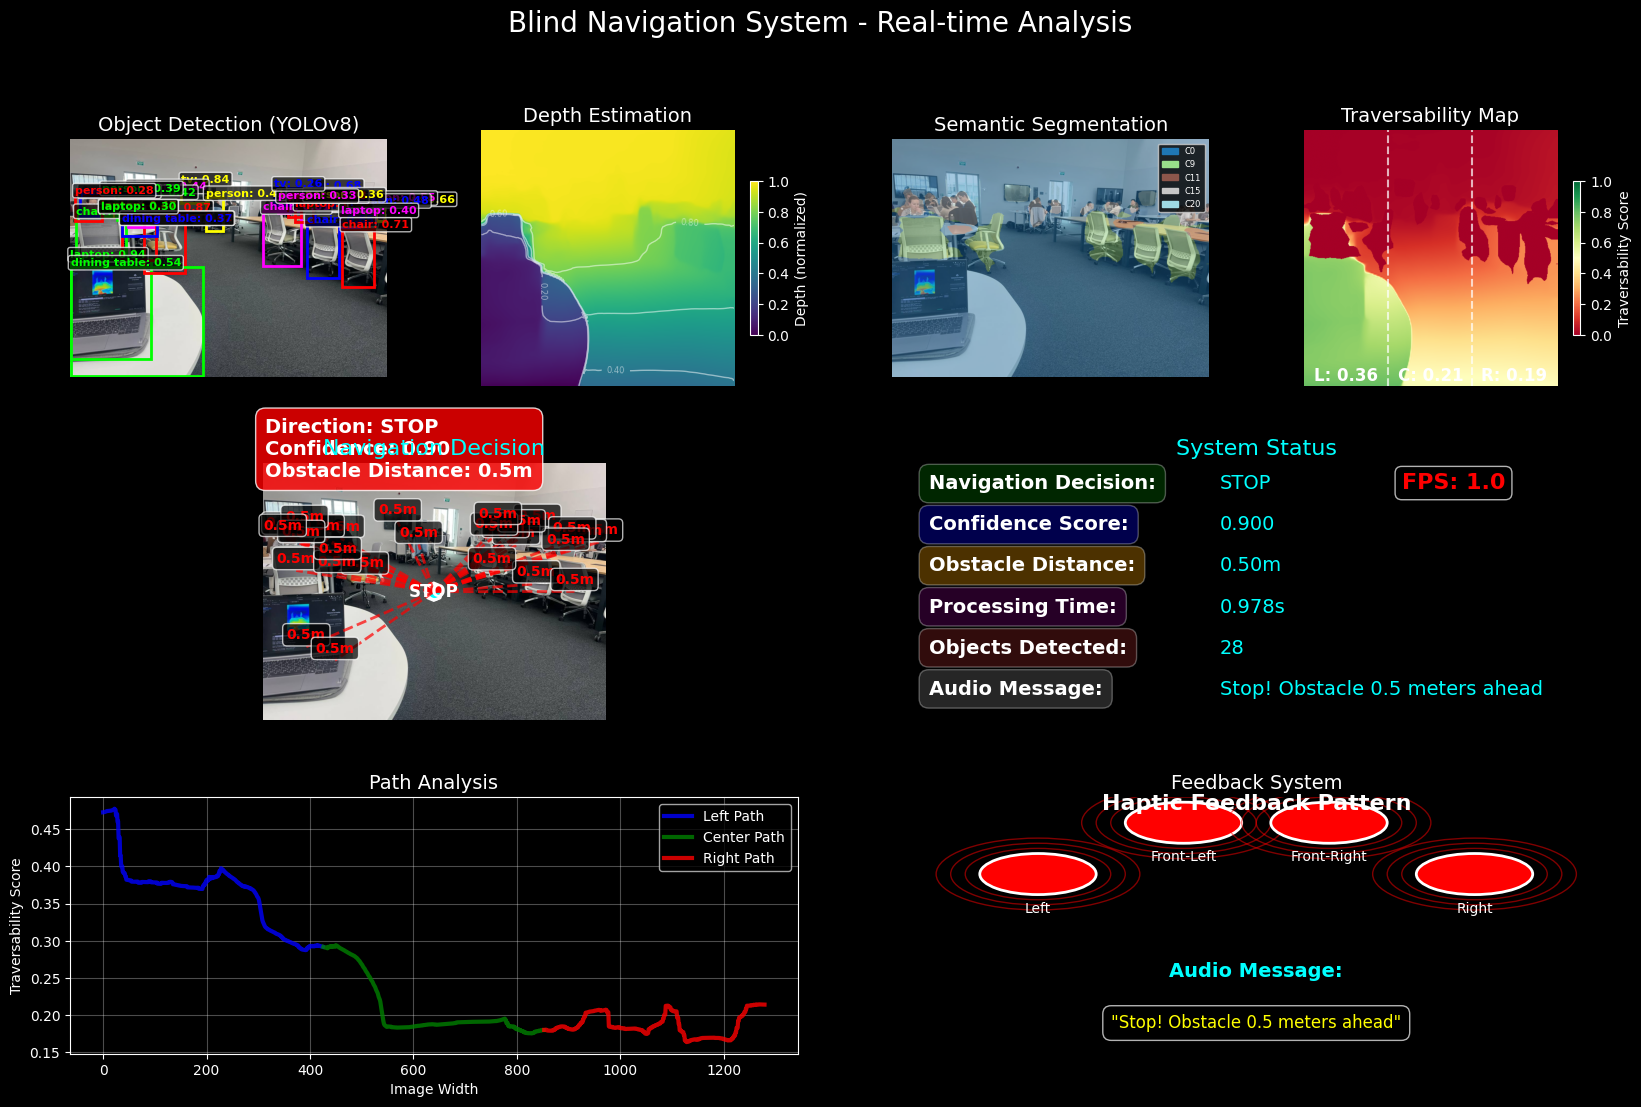

Creating simple overlay...


original_size: (1280, 960)

0: 480x640 12 persons, 5 chairs, 3 dining tables, 3 tvs, 5 laptops, 57.4ms
Speed: 4.1ms preprocess, 57.4ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


: 

: 

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
import torch
import time
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class NavigationVisualizer:
    """Comprehensive visualization system for the blind navigation system"""
    
    def __init__(self, figsize=(20, 12)):
        self.figsize = figsize
        plt.style.use('dark_background')
        
        # Color schemes for different visualizations
        self.colors = {
            'depth': 'viridis',
            'segmentation': 'tab20',
            'detection': [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)],
            'traversability': 'RdYlGn',
            'path': (0, 255, 255),
            'obstacle': (255, 0, 0),
            'safe': (0, 255, 0)
        }
        
        # Class names for COCO dataset (YOLOv8)
        self.coco_classes = [
            'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
            'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench',
            'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
            'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
            'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
            'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
            'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
            'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse',
            'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
            'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
            'toothbrush'
        ]
    
    def create_comprehensive_visualization(self, navigator, image_path, save_path=None):
        """Create comprehensive visualization of all system components"""
        
        # Process the frame
        start_time = time.time()
        navigation_result = navigator.process_frame(image_path)
        processing_time = time.time() - start_time
        
        # Load original image
        if isinstance(image_path, str):
            original_image = cv2.imread(image_path)
            if original_image is None:
                original_image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
        else:
            original_image = image_path.copy()
        
        # Create the visualization
        fig = plt.figure(figsize=self.figsize)
        
        # Define grid layout
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        # 1. Original Image with Object Detection
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_object_detection(ax1, original_image, navigator.current_detections)
        ax1.set_title('Object Detection (YOLOv8)', fontsize=14, color='white')
        
        # 2. Depth Map
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_depth_map(ax2, navigator.current_depth)
        ax2.set_title('Depth Estimation', fontsize=14, color='white')
        
        # 3. Semantic Segmentation
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_segmentation(ax3, navigator.current_segmentation, original_image)
        ax3.set_title('Semantic Segmentation', fontsize=14, color='white')
        
        # 4. Traversability Map
        ax4 = fig.add_subplot(gs[0, 3])
        traversability_map = self._create_traversability_visualization(navigator, original_image.shape[:2])
        self._plot_traversability_map(ax4, traversability_map)
        ax4.set_title('Traversability Map', fontsize=14, color='white')
        
        # 5. Navigation Decision Overlay
        ax5 = fig.add_subplot(gs[1, :2])
        self._plot_navigation_overlay(ax5, original_image, navigation_result, navigator)
        ax5.set_title('Navigation Decision', fontsize=16, color='cyan')
        
        # 6. System Status and Metrics
        ax6 = fig.add_subplot(gs[1, 2:])
        self._plot_system_status(ax6, navigation_result, processing_time, navigator)
        ax6.set_title('System Status', fontsize=16, color='cyan')
        
        # 7. Path Analysis
        ax7 = fig.add_subplot(gs[2, :2])
        self._plot_path_analysis(ax7, traversability_map, navigation_result)
        ax7.set_title('Path Analysis', fontsize=14, color='white')
        
        # 8. Haptic and Audio Feedback
        ax8 = fig.add_subplot(gs[2, 2:])
        self._plot_feedback_system(ax8, navigation_result)
        ax8.set_title('Feedback System', fontsize=14, color='white')
        
        # Add main title
        fig.suptitle('Blind Navigation System - Real-time Analysis', 
                    fontsize=20, color='white', y=0.98)
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight', 
                       facecolor='black', edgecolor='none')
            print(f"Visualization saved to: {save_path}")
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def _plot_object_detection(self, ax, image, detections):
        """Plot object detection results"""
        try:
            # Convert BGR to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            
            # Draw bounding boxes and labels
            if detections and len(detections) > 0:
                for i, detection in enumerate(detections):
                    try:
                        bbox = detection['bbox']
                        confidence = detection['confidence']
                        class_name = detection['class']
                        
                        # Choose color
                        color = self.colors['detection'][i % len(self.colors['detection'])]
                        color_norm = [c/255.0 for c in color]
                        
                        # Ensure bbox coordinates are valid
                        x1, y1, x2, y2 = max(0, bbox[0]), max(0, bbox[1]), bbox[2], bbox[3]
                        width, height = max(1, x2 - x1), max(1, y2 - y1)
                        
                        # Draw bounding box
                        rect = patches.Rectangle(
                            (x1, y1), width, height,
                            linewidth=2, edgecolor=color_norm, facecolor='none'
                        )
                        ax.add_patch(rect)
                        
                        # Add label
                        label_text = f'{class_name}: {confidence:.2f}'
                        ax.text(x1, max(0, y1-5), label_text,
                               fontsize=8, color=color_norm, weight='bold',
                               bbox=dict(boxstyle="round,pad=0.2", facecolor='black', alpha=0.7))
                    except Exception as e:
                        print(f"Error drawing detection {i}: {e}")
                        continue
            
            ax.set_xlim(0, image.shape[1])
            ax.set_ylim(image.shape[0], 0)
            
        except Exception as e:
            print(f"Object detection visualization error: {e}")
            # Show original image as fallback
            try:
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                ax.imshow(image_rgb)
            except:
                ax.text(0.5, 0.5, 'Image Display\nError', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, color='red')
        
        ax.axis('off')
    
    def _plot_depth_map(self, ax, depth_map):
        """Plot depth estimation results"""
        if depth_map is not None and depth_map.size > 0:
            try:
                # Ensure depth map is 2D
                if len(depth_map.shape) > 2:
                    depth_map = depth_map.squeeze()
                
                # Handle any NaN or infinite values
                depth_map = np.nan_to_num(depth_map, nan=0.5, posinf=1.0, neginf=0.0)
                
                # Normalize depth map
                if depth_map.max() > depth_map.min():
                    depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
                else:
                    depth_normalized = np.ones_like(depth_map) * 0.5
                
                im = ax.imshow(depth_normalized, cmap=self.colors['depth'], aspect='auto')
                plt.colorbar(im, ax=ax, shrink=0.6, label='Depth (normalized)')
                
                # Add depth contours (with error handling)
                try:
                    contours = ax.contour(depth_normalized, levels=5, colors='white', 
                                        alpha=0.5, linewidths=1)
                    ax.clabel(contours, inline=True, fontsize=6, fmt='%.2f')
                except:
                    pass  # Skip contours if they fail
                    
            except Exception as e:
                print(f"Depth visualization error: {e}")
                ax.text(0.5, 0.5, 'Depth Visualization\nError', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, color='red', weight='bold')
        else:
            ax.text(0.5, 0.5, 'Depth Estimation\nNot Available', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, color='yellow', weight='bold')
        
        ax.axis('off')
    
    def _plot_segmentation(self, ax, segmentation, original_image):
        """Plot semantic segmentation results"""
        if segmentation is not None and segmentation.size > 0:
            try:
                # Get original image dimensions
                orig_h, orig_w = original_image.shape[:2]
                
                # Resize segmentation to match original image
                if segmentation.shape != (orig_h, orig_w):
                    segmentation_resized = cv2.resize(segmentation, (orig_w, orig_h), 
                                                    interpolation=cv2.INTER_NEAREST)
                else:
                    segmentation_resized = segmentation
                
                # Create colored segmentation map
                colored_seg = np.zeros((orig_h, orig_w, 3), dtype=np.uint8)
                unique_classes = np.unique(segmentation_resized)
                
                # Limit number of colors to avoid matplotlib issues
                n_classes = min(len(unique_classes), 20)
                colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
                
                for i, class_id in enumerate(unique_classes[:n_classes]):
                    mask = (segmentation_resized == class_id)
                    if i < len(colors):
                        colored_seg[mask] = (colors[i][:3] * 255).astype(np.uint8)
                
                # Convert original image to RGB and ensure same size
                original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                
                # Ensure both images have the same dimensions
                if original_rgb.shape[:2] != colored_seg.shape[:2]:
                    colored_seg = cv2.resize(colored_seg, (original_rgb.shape[1], original_rgb.shape[0]))
                
                # Blend with original image
                blended = cv2.addWeighted(original_rgb, 0.6, colored_seg, 0.4, 0)
                
                ax.imshow(blended)
                
                # Add legend for classes (simplified)
                legend_elements = []
                display_classes = unique_classes[:min(8, len(unique_classes))]  # Show max 8 classes
                for i, class_id in enumerate(display_classes):
                    if i < len(colors):
                        color = colors[i][:3]  # RGB values
                        legend_elements.append(patches.Patch(color=color, label=f'C{class_id}'))
                
                if legend_elements:
                    ax.legend(handles=legend_elements, loc='upper right', fontsize=6, 
                            framealpha=0.8, fancybox=True)
                
            except Exception as e:
                print(f"Segmentation visualization error: {e}")
                # Fallback: show original image
                original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
                ax.imshow(original_rgb)
                ax.text(0.5, 0.95, 'Segmentation Error', 
                       ha='center', va='top', transform=ax.transAxes,
                       fontsize=10, color='red', weight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        else:
            # Show original image when segmentation is not available
            original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            ax.imshow(original_rgb)
            ax.text(0.5, 0.5, 'Segmentation\nNot Available', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=12, color='yellow', weight='bold',
                   bbox=dict(boxstyle="round,pad=0.5", facecolor='black', alpha=0.7))
        
        ax.axis('off')
    
    def _create_traversability_visualization(self, navigator, image_shape):
        """Create traversability map for visualization"""
        h, w = image_shape
        
        try:
            if (hasattr(navigator, 'current_segmentation') and 
                hasattr(navigator, 'current_depth') and
                navigator.current_segmentation is not None and
                navigator.current_depth is not None and
                navigator.current_segmentation.size > 0 and
                navigator.current_depth.size > 0):
                
                # Ensure segmentation is 2D
                seg = navigator.current_segmentation
                if len(seg.shape) > 2:
                    seg = seg.squeeze()
                
                # Ensure depth is 2D  
                depth = navigator.current_depth
                if len(depth.shape) > 2:
                    depth = depth.squeeze()
                
                # Resize to match target dimensions
                seg_resized = cv2.resize(seg.astype(np.float32), (w, h), 
                                       interpolation=cv2.INTER_NEAREST).astype(np.int32)
                depth_resized = cv2.resize(depth.astype(np.float32), (w, h))
                
                # Handle potential issues with segmenter
                if hasattr(navigator, 'semantic_segmenter') and navigator.semantic_segmenter is not None:
                    try:
                        traversability = navigator.semantic_segmenter.create_traversability_map(
                            seg_resized, depth_resized
                        )
                    except Exception as e:
                        print(f"Traversability map creation error: {e}")
                        # Create simple traversability based on depth only
                        traversability = 1.0 - (depth_resized / (np.max(depth_resized) + 1e-8))
                else:
                    # Simple traversability based on depth only
                    traversability = 1.0 - (depth_resized / (np.max(depth_resized) + 1e-8))
            else:
                # Create dummy traversability map
                print("Creating dummy traversability map - missing data")
                x, y = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
                traversability = 0.5 + 0.3 * np.sin(x * 4) * np.cos(y * 4)
                traversability = np.clip(traversability, 0, 1)
                
        except Exception as e:
            print(f"Traversability creation error: {e}")
            # Final fallback
            traversability = np.random.rand(h, w) * 0.5 + 0.3
        
        return traversability
    
    def _plot_traversability_map(self, ax, traversability_map):
        """Plot traversability map"""
        im = ax.imshow(traversability_map, cmap=self.colors['traversability'], 
                      vmin=0, vmax=1, aspect='auto')
        
        plt.colorbar(im, ax=ax, shrink=0.6, label='Traversability Score')
        
        # Add grid to show path analysis
        h, w = traversability_map.shape
        ax.axvline(x=w//3, color='white', linestyle='--', alpha=0.7, label='Left')
        ax.axvline(x=2*w//3, color='white', linestyle='--', alpha=0.7, label='Right')
        
        # Calculate and show scores
        left_score = np.mean(traversability_map[:, :w//3])
        center_score = np.mean(traversability_map[:, w//3:2*w//3])
        right_score = np.mean(traversability_map[:, 2*w//3:])
        
        ax.text(w//6, h-20, f'L: {left_score:.2f}', ha='center', color='white', 
               fontsize=12, weight='bold')
        ax.text(w//2, h-20, f'C: {center_score:.2f}', ha='center', color='white', 
               fontsize=12, weight='bold')
        ax.text(5*w//6, h-20, f'R: {right_score:.2f}', ha='center', color='white', 
               fontsize=12, weight='bold')
        
        ax.axis('off')
    
    def _plot_navigation_overlay(self, ax, image, navigation_result, navigator):
        """Plot navigation decision overlay on original image"""
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb)
        
        h, w = image.shape[:2]
        center_x, center_y = w // 2, h // 2
        
        # Draw center point
        ax.plot(center_x, center_y, 'o', color='cyan', markersize=10, 
               markeredgecolor='white', markeredgewidth=2)
        
        # Draw direction arrow
        arrow_length = min(w, h) // 4
        direction = navigation_result.direction
        
        if direction == "forward":
            ax.arrow(center_x, center_y, 0, -arrow_length, 
                    head_width=20, head_length=20, fc='green', ec='white', linewidth=3)
            arrow_color = 'green'
        elif direction == "left":
            ax.arrow(center_x, center_y, -arrow_length, 0, 
                    head_width=20, head_length=20, fc='blue', ec='white', linewidth=3)
            arrow_color = 'blue'
        elif direction == "right":
            ax.arrow(center_x, center_y, arrow_length, 0, 
                    head_width=20, head_length=20, fc='blue', ec='white', linewidth=3)
            arrow_color = 'blue'
        else:  # stop
            # Draw stop sign
            stop_sign = patches.RegularPolygon((center_x, center_y), 8, radius=30, 
                                             facecolor='red', edgecolor='white', linewidth=3)
            ax.add_patch(stop_sign)
            ax.text(center_x, center_y, 'STOP', ha='center', va='center', 
                   color='white', fontsize=12, weight='bold')
            arrow_color = 'red'
        
        # Draw obstacle indicators
        for detection in navigator.current_detections:
            bbox = detection['bbox']
            obj_center_x = (bbox[0] + bbox[2]) / 2
            obj_center_y = (bbox[1] + bbox[3]) / 2
            
            # Draw line from center to obstacle
            ax.plot([center_x, obj_center_x], [center_y, obj_center_y], 
                   'r--', linewidth=2, alpha=0.7)
            
            # Distance estimate
            distance = navigation_result.obstacle_distance
            ax.text(obj_center_x, obj_center_y-30, f'{distance:.1f}m', 
                   ha='center', color='red', fontsize=10, weight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
        
        # Add status text
        status_text = f"Direction: {direction.upper()}\n"
        status_text += f"Confidence: {navigation_result.confidence:.2f}\n"
        status_text += f"Obstacle Distance: {navigation_result.obstacle_distance:.1f}m"
        
        ax.text(10, 50, status_text, fontsize=14, color='white', weight='bold',
               bbox=dict(boxstyle="round,pad=0.5", facecolor=arrow_color, alpha=0.8))
        
        ax.set_xlim(0, w)
        ax.set_ylim(h, 0)
        ax.axis('off')
    
    def _plot_system_status(self, ax, navigation_result, processing_time, navigator):
        """Plot system status and metrics"""
        ax.axis('off')
        
        # Create status dashboard
        status_data = {
            'Navigation Decision': navigation_result.direction.upper(),
            'Confidence Score': f"{navigation_result.confidence:.3f}",
            'Obstacle Distance': f"{navigation_result.obstacle_distance:.2f}m",
            'Processing Time': f"{processing_time:.3f}s",
            'Objects Detected': len(navigator.current_detections),
            'Audio Message': navigation_result.audio_message
        }
        
        # Create colored boxes for each status
        y_positions = np.linspace(0.9, 0.1, len(status_data))
        colors = ['green', 'blue', 'orange', 'purple', 'brown', 'gray']
        
        for i, (key, value) in enumerate(status_data.items()):
            # Background box
            bbox_props = dict(boxstyle="round,pad=0.5", facecolor=colors[i], alpha=0.3)
            ax.text(0.05, y_positions[i], f"{key}:", fontsize=14, weight='bold', 
                   color='white', transform=ax.transAxes, bbox=bbox_props)
            ax.text(0.45, y_positions[i], str(value), fontsize=14, 
                   color='cyan', transform=ax.transAxes)
        
        # Add performance indicators
        fps = 1.0 / max(processing_time, 0.001)
        performance_color = 'green' if fps > 10 else 'yellow' if fps > 5 else 'red'
        
        ax.text(0.7, 0.9, f"FPS: {fps:.1f}", fontsize=16, weight='bold',
               color=performance_color, transform=ax.transAxes,
               bbox=dict(boxstyle="round,pad=0.3", facecolor='black', alpha=0.7))
    
    def _plot_path_analysis(self, ax, traversability_map, navigation_result):
        """Plot detailed path analysis"""
        h, w = traversability_map.shape
        
        # Create path analysis visualization
        x_coords = np.arange(w)
        
        # Calculate path scores for different sections
        left_path = np.mean(traversability_map[:, :w//3], axis=0)
        center_path = np.mean(traversability_map[:, w//3:2*w//3], axis=0)
        right_path = np.mean(traversability_map[:, 2*w//3:], axis=0)
        
        # Plot path scores
        ax.plot(x_coords[:w//3], left_path, 'b-', linewidth=3, label='Left Path', alpha=0.8)
        ax.plot(x_coords[w//3:2*w//3], center_path, 'g-', linewidth=3, label='Center Path', alpha=0.8)
        ax.plot(x_coords[2*w//3:], right_path, 'r-', linewidth=3, label='Right Path', alpha=0.8)
        
        # Highlight chosen direction
        direction = navigation_result.direction
        if direction == "left":
            ax.fill_between(x_coords[:w//3], 0, left_path, alpha=0.3, color='blue')
        elif direction == "forward":
            ax.fill_between(x_coords[w//3:2*w//3], 0, center_path, alpha=0.3, color='green')
        elif direction == "right":
            ax.fill_between(x_coords[2*w//3:], 0, right_path, alpha=0.3, color='red')
        
        ax.set_xlabel('Image Width', color='white')
        ax.set_ylabel('Traversability Score', color='white')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(colors='white')
    
    def _plot_feedback_system(self, ax, navigation_result):
        """Plot haptic and audio feedback system"""
        ax.axis('off')
        
        # Haptic feedback visualization
        haptic_pattern = navigation_result.haptic_pattern
        motor_names = ['Left', 'Front-Left', 'Front-Right', 'Right']
        
        # Create motor visualization
        motor_positions = [(0.2, 0.7), (0.4, 0.9), (0.6, 0.9), (0.8, 0.7)]
        
        ax.text(0.5, 0.95, 'Haptic Feedback Pattern', ha='center', fontsize=16, 
               color='white', weight='bold', transform=ax.transAxes)
        
        for i, (pos, name) in enumerate(zip(motor_positions, motor_names)):
            # Motor representation
            active = haptic_pattern[i] if i < len(haptic_pattern) else 0
            color = 'red' if active else 'gray'
            alpha = 1.0 if active else 0.3
            
            circle = patches.Circle(pos, 0.08, facecolor=color, alpha=alpha, 
                                  edgecolor='white', linewidth=2)
            ax.add_patch(circle)
            ax.text(pos[0], pos[1]-0.15, name, ha='center', fontsize=10, 
                   color='white', transform=ax.transAxes)
            
            if active:
                # Add vibration effect
                for r in [0.1, 0.12, 0.14]:
                    vibration = patches.Circle(pos, r, fill=False, 
                                             edgecolor=color, alpha=0.5, linewidth=1)
                    ax.add_patch(vibration)
        
        # Audio feedback
        audio_msg = navigation_result.audio_message
        wrapped_msg = '\n'.join([audio_msg[i:i+40] for i in range(0, len(audio_msg), 40)])
        
        ax.text(0.5, 0.3, 'Audio Message:', ha='center', fontsize=14, 
               color='cyan', weight='bold', transform=ax.transAxes)
        ax.text(0.5, 0.1, f'"{wrapped_msg}"', ha='center', fontsize=12, 
               color='yellow', transform=ax.transAxes,
               bbox=dict(boxstyle="round,pad=0.5", facecolor='black', alpha=0.7))
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

def create_simple_overlay_visualization(navigator, image_path, save_path=None):
    """Create a simple overlay visualization for quick testing"""
    try:
        # Process the frame
        navigation_result = navigator.process_frame(image_path)
        
        # Load image
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not load image: {image_path}")
                image = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
        else:
            image = image_path.copy()
        
        # Create visualization overlay
        overlay = image.copy()
        h, w = image.shape[:2]
        center_x, center_y = w // 2, h // 2
        
        # Draw center point
        cv2.circle(overlay, (center_x, center_y), 8, (0, 255, 255), -1)
        cv2.circle(overlay, (center_x, center_y), 10, (255, 255, 255), 2)
        
        # Draw navigation decision
        direction = navigation_result.direction
        arrow_length = min(w, h) // 6
        
        if direction == "forward":
            end_point = (center_x, center_y - arrow_length)
            cv2.arrowedLine(overlay, (center_x, center_y), end_point, 
                           (0, 255, 0), thickness=8, tipLength=0.3)
            color = (0, 255, 0)
        elif direction == "left":
            end_point = (center_x - arrow_length, center_y)
            cv2.arrowedLine(overlay, (center_x, center_y), end_point, 
                           (255, 0, 0), thickness=8, tipLength=0.3)
            color = (255, 0, 0)
        elif direction == "right":
            end_point = (center_x + arrow_length, center_y)
            cv2.arrowedLine(overlay, (center_x, center_y), end_point, 
                           (255, 0, 0), thickness=8, tipLength=0.3)
            color = (255, 0, 0)
        else:  # stop
            cv2.circle(overlay, (center_x, center_y), 40, (0, 0, 255), thickness=8)
            cv2.putText(overlay, "STOP", (center_x-35, center_y+8), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
            color = (0, 0, 255)
        
        # Draw object detection boxes
        if hasattr(navigator, 'current_detections') and navigator.current_detections:
            for i, detection in enumerate(navigator.current_detections):
                try:
                    bbox = detection['bbox']
                    confidence = detection['confidence']
                    class_name = detection['class']
                    
                    # Ensure valid coordinates
                    x1, y1 = int(max(0, bbox[0])), int(max(0, bbox[1]))
                    x2, y2 = int(min(w, bbox[2])), int(min(h, bbox[3]))
                    
                    # Box color based on detection index
                    box_colors = [(0, 255, 255), (255, 255, 0), (255, 0, 255), (0, 255, 0)]
                    box_color = box_colors[i % len(box_colors)]
                    
                    cv2.rectangle(overlay, (x1, y1), (x2, y2), box_color, 3)
                    
                    # Label background
                    label = f'{class_name}: {confidence:.2f}'
                    (text_width, text_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                    cv2.rectangle(overlay, (x1, y1-text_height-10), (x1+text_width+10, y1), 
                                 box_color, -1)
                    cv2.putText(overlay, label, (x1+5, y1-5), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
                    
                    # Distance line
                    obj_center_x = (x1 + x2) // 2
                    obj_center_y = (y1 + y2) // 2
                    cv2.line(overlay, (center_x, center_y), (obj_center_x, obj_center_y), 
                            (255, 255, 255), 2, cv2.LINE_AA)
                    
                except Exception as e:
                    print(f"Error drawing detection overlay: {e}")
                    continue
        
        # Add status information background
        info_height = 120
        cv2.rectangle(overlay, (10, 10), (w-10, info_height), (0, 0, 0), -1)
        cv2.rectangle(overlay, (10, 10), (w-10, info_height), color, 3)
        
        # Add status text
        y_offset = 35
        font_scale = 0.8
        thickness = 2
        
        status_lines = [
            f"Direction: {direction.upper()}",
            f"Obstacle Distance: {navigation_result.obstacle_distance:.1f}m",
            f"Confidence: {navigation_result.confidence:.2f}",
            f"Objects Detected: {len(navigator.current_detections) if hasattr(navigator, 'current_detections') else 0}"
        ]
        
        for i, line in enumerate(status_lines):
            cv2.putText(overlay, line, (20, y_offset + i*22), 
                       cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)
        
        # Add audio message at bottom
        if len(navigation_result.audio_message) > 0:
            # Split long messages
            audio_msg = navigation_result.audio_message
            if len(audio_msg) > 50:
                audio_msg = audio_msg[:47] + "..."
            
            msg_y = h - 30
            cv2.rectangle(overlay, (10, msg_y-25), (w-10, h-10), (50, 50, 50), -1)
            cv2.putText(overlay, f'Audio: "{audio_msg}"', (20, msg_y), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
        
        if save_path:
            cv2.imwrite(save_path, overlay)
            print(f"Simple visualization saved to: {save_path}")
        
        return overlay
        
    except Exception as e:
        print(f"Error creating simple overlay: {e}")
        # Return a basic error overlay
        error_image = np.zeros((480, 640, 3), dtype=np.uint8)
        cv2.putText(error_image, "Visualization Error", (200, 240), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        return error_image

# Example usage functions
def visualize_navigation_system(navigator, image_path="../images/image5.png"):
    """Main visualization function"""
    print("Creating comprehensive visualization...")
    
    # Create visualizer
    visualizer = NavigationVisualizer(figsize=(20, 12))
    
    # Generate comprehensive visualization
    fig = visualizer.create_comprehensive_visualization(
        navigator, image_path, save_path=f"../images/navigation_analysis_1.png"
    )
    
    # Also create simple overlay
    print("Creating simple overlay...")
    simple_overlay = create_simple_overlay_visualization(
        navigator, image_path, save_path="../images/navigation_overlay.jpg"
    )
    
    # Display simple overlay using OpenCV
    cv2.imshow('Navigation Overlay', simple_overlay)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    return fig, simple_overlay

# Test function
if __name__ == "__main__":
    # Import the main navigation system
    # from blind_navigation_system import NavigationDecisionMaker
    
    print("Initializing navigation system for visualization...")
    
    # Initialize navigator
    devices = ['cuda:0', 'cuda:0'] if torch.cuda.device_count() >= 1 else ['cpu', 'cpu']
    navigator = NavigationDecisionMaker(cuda_devices=devices)
    
    # Run visualization
    visualize_navigation_system(navigator, "../images/image5.png")